<a href="https://colab.research.google.com/github/amerajat/AI07-Crack-images-for-Classification/blob/main/Copy_of_Crack_Images_for_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [2]:
SEED = 42
IMG_SIZE = (100,100)
BATCH_SIZE = 32

train_dataset = keras.utils.image_dataset_from_directory(r"/content/drive/MyDrive/Concrete Crack Images for Classification", 
                                                         seed = SEED, image_size = IMG_SIZE, batch_size = BATCH_SIZE, subset = 'training', validation_split = 0.3)
val_ds = keras.utils.image_dataset_from_directory(r"/content/drive/MyDrive/Concrete Crack Images for Classification", 
                                                    seed = SEED, image_size = IMG_SIZE, batch_size = BATCH_SIZE, subset = 'validation', validation_split = 0.3)

Found 40000 files belonging to 4 classes.
Using 28000 files for training.
Found 40000 files belonging to 4 classes.
Using 12000 files for validation.


# Preprocessing the data

In [3]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches//5)
val_dataset = val_ds.skip(val_batches//5)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
pf_train = train_dataset.prefetch(buffer_size = AUTOTUNE)
pf_val = val_dataset.prefetch(buffer_size = AUTOTUNE)
pf_test = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [24]:
data_aug = tf.keras.Sequential()
data_aug.add(tf.keras.layers.RandomFlip())
data_aug.add(tf.keras.layers.RandomRotation(0.3))

In [16]:
feature_ext_layer = tf.keras.applications.resnet50.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
class_names = train_dataset.class_names
base_model = tf.keras.applications.ResNet50(include_top = False, weights = "imagenet", input_shape = IMG_SHAPE)

base_model.trainable = False


In [25]:
avg_layer = tf.keras.layers.GlobalAveragePooling2D()
output_layer = tf.keras.layers.Dense(len(class_names), activation="softmax")
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_aug(inputs)
x = feature_ext_layer(x)
x = base_model(x, training=False)
x = avg_layer(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 100, 100, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0   

In [9]:
model.compile(optimizer= "adam", loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [11]:
import datetime, os

base_log_path = r"/content/tb_logs"
log_path = os.path.join(base_log_path, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_path)
es_cb = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 2, min_delta = 0.2)
EPOCHS = 50


history = model.fit(pf_train, validation_data=pf_val, epochs=EPOCHS, callbacks=[tb_cb,es_cb])                                           

Epoch 1/50
875/875 [==============================] - 2759s 3s/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0066 - val_accuracy: 0.9980
Epoch 2/50
875/875 [==============================] - 69s 78ms/step - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0056 - val_accuracy: 0.9984
Epoch 3/50
875/875 [==============================] - 68s 77ms/step - loss: 0.0060 - accuracy: 0.9980 - val_loss: 0.0047 - val_accuracy: 0.9986


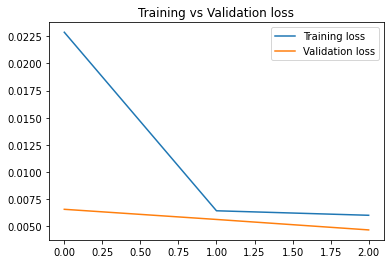

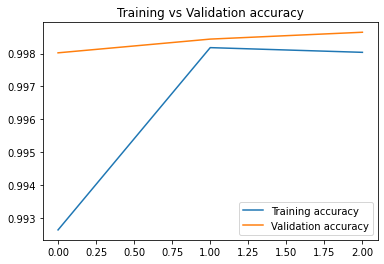

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = history.epoch

plt.plot(epochs, train_loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training vs Validation loss")
plt.legend()
plt.figure()

plt.plot(epochs, train_acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training vs Validation accuracy")
plt.legend()
plt.figure()

plt.show()

In [13]:
loss, accuracy = model.evaluate(pf_test)

print(f"loss = {loss}")
print(f"Accuracy = {accuracy}")

75/75 [==============================] - 5s 56ms/step - loss: 0.0025 - accuracy: 0.9996
loss = 0.0025248383171856403
Accuracy = 0.9995833039283752


In [14]:
image_batch, label_batch = pf_test.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions,axis=1)

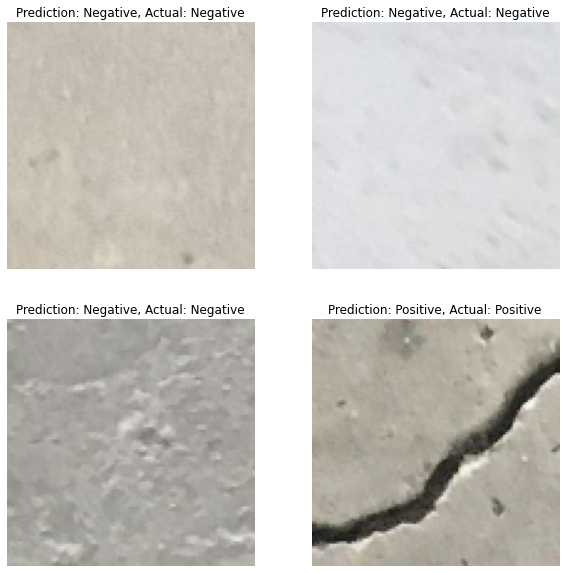

In [23]:
import matplotlib.pyplot as plt

#7. Show some prediction results
plt.figure(figsize=(10,10))

for i in range(4):
    axs = plt.subplot(2,2,i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    current_prediction = class_names[class_predictions[i]]
    current_label = class_names[label_batch[i]]
    plt.title(f"Prediction: {current_prediction}, Actual: {current_label}")
    plt.axis('off')
    
save_path = r"/content/drive/MyDrive/Concrete Crack Images for Classification/result"
plt.savefig(os.path.join(save_path,"result.png"),bbox_inches='tight')
plt.show()
